# VGAE framework

In [1]:
import torch
from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops)
from torch_geometric.nn.inits import reset 
EPS = 1e-15
MAX_LOGSTD = 1
 
class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""
    def forward(self, z, edge_index, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value


    def forward_all(self, z, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                    the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj



class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (Module): The encoder module.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, w1=1, w2=1, decoder=None):
        super(GAE, self).__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        self.w1 = w1
        self.w2 = w2
        GAE.reset_parameters(self)

    def reset_parameters(self):
        reset(self.encoder)
        reset(self.decoder)


    def encode(self, *args, **kwargs):
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)


    def decode(self, *args, **kwargs):
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)


    def recon_loss(self, z, pos_edge_index, neg_edge_index=None):
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :oenbj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to train against.
            neg_edge_index (LongTensor, optional): The negative edges to train
                against. If not given, uses negative sampling to calculate
                negative edges. (default: :obj:`None`)
        """

        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True) + EPS).sum()

        # Do not include self-loops in negative samples
        pos_edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index, _ = add_self_loops(pos_edge_index)
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).sum()
        N1 = len(-torch.log( self.decoder(z, pos_edge_index, sigmoid=True) + EPS))
        N2 = len(-torch.log(1 - self.decoder(z, neg_edge_index, sigmoid=True) + EPS))

        return (self.w1 * pos_loss + self.w2 * neg_loss) / (N1+N2)


    def test(self, z, pos_edge_index, neg_edge_index):
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        scores.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to evaluate
                against.
            neg_edge_index (LongTensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import roc_auc_score, average_precision_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)
        
        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)



class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (Module): The encoder module to compute :math:`\mu` and
            :math:`\log\sigma^2`.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, w1=1, w2=1, decoder=None):
        super(VGAE, self).__init__(encoder, w1, w2, decoder)
        self.w1 = w1
        self.w2 = w2

    def reparametrize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu
    
    def encode(self, *args, **kwargs):
        """"""
        self.__mu__, self.__logstd__ = self.encoder(*args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z

    def kl_loss(self, mu=None, logstd=None):
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (Tensor, optional): The latent space for :math:`\mu`. If set to
                :obj:`None`, uses the last computation of :math:`mu`.
                (default: :obj:`None`)
            logstd (Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`.(default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1)) 

# IPF data

## Data class

In [2]:
import torch
from torch.autograd.grad_mode import F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

import scipy.sparse as sp
import numpy as np
import networkx as nx

class SimuData():
    """Simulate graph data"""
    def __init__(self, p=0.5, n_node=10, n_graph=30):
        self.n_node = n_node
        self.n_graph = n_graph
        self.p = p

    def simu_adj_wgh(self):
        adj_list = []

        for i in range(self.n_graph):
            ## zero matrix
            A = torch.zeros(self.n_node, self.n_node)
            # first five nodes weights: uniform(0,1)A[:5,:5] = W
            W = torch.rand(5, 5)
            ## symmetric
            i, j = torch.triu_indices(5, 5)
            W[i, j] = W.T[i, j]
            A[:5, :5] = W
            adj_list.append(A)  

        return adj_list

    def simu_adj_diag(self):
        adj_list = []

        for i in range(self.n_graph):
            A = torch.eye(self.n_node)
            adj_list.append(A)  

        return adj_list

    def simu_adj_m(self):
        """generating adjacency matrix"""
        adj_wgh = self.simu_adj_wgh()
        #adj_wgh = self.simu_adj_diag()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj>=1-self.p] = 1
            adj[adj<1-self.p] = 0
            adj_m_list.append(adj)    
        return adj_m_list

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.simu_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            x = self.get_x_feature()
            data = Data(x=x, edge_index=edge_index_A)
            dataset.append(data)

        return dataset

    def get_x_feature(self):
        x = torch.arange(self.n_node)
        x_onehot = torch.eye(self.n_node)[x,:] 

        return torch.FloatTensor(x_onehot)


class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=False) 
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=False)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


transform = T.Compose([
            T.NormalizeFeatures(),
            T.RandomLinkSplit(num_val=0, num_test=0, is_undirected=True,
                            split_labels=True, add_negative_train_samples=False),])

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix


class LoadData():
    """Load graph data"""
    def __init__(self, file_path, samples, non_orphan_list=None, n_node=38):
        self.samples = samples
        self.file_path = file_path
        self.nSample = len(samples)
        self.non_orphan_list = non_orphan_list
        self.n_node = n_node

    def get_adj_wgh(self):
        """generating adjacency matrix"""
        adj_orig_list =[]
        for sample in self.samples:
            f_name = self.file_path + "/"+ sample
            adj   = np.asarray(pd.read_csv(f_name, index_col = 0, iterator = False))
            adj_orig_list.append(adj)    

        return adj_orig_list

    def get_adj_label(self):
        adj_m = self.get_adj_m()
        adj_label_list =[]
        
        for _, adj in enumerate(adj_m):
            adj_label = adj + sp.eye(adj.shape[0])
            adj_label = sparse_to_tuple(sp.coo_matrix(adj_label))
            #adj_label = sparse_to_tuple(adj_label)
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T), 
                            torch.FloatTensor(adj_label[1]), 
                            torch.Size(adj_label[2]))
            adj_label_list.append(adj_label)
        return adj_label_list

    def get_adj_norm(self):
        adj_m = self.get_adj_m()
        adj_norm_list =[]

        for _, adj in enumerate(adj_m):
            adj_norm = preprocess_graph(adj)
            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T), 
                            torch.FloatTensor(adj_norm[1]), 
                            torch.Size(adj_norm[2]))
            adj_norm_list.append(adj_norm)

        return adj_norm_list

    def get_adj_m(self):
        adj_wgh = self.get_adj_wgh()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj > 0] = 1
            for i in range(self.n_node):
                adj[i, i] = 0
            for i in range(self.n_node):
                for j in range(self.n_node):
                    if adj[i, j] == 1:
                        adj[j, i] = 1
            for i in range(self.n_node - 1, -1, -1):
                if i not in self.non_orphan_list:
                    adj = np.delete(adj, (i), axis=0)
                    adj = np.delete(adj, (i), axis=1)
            adj_m_list.append(adj)    
        return adj_m_list

    def get_feature(self):
        """generating feature matrix X"""
        adj_wgh = self.get_adj_wgh()
        x_list = []
        for _, adj in enumerate(adj_wgh):
            x_feature  = adj
            x_feature  = csr_matrix(x_feature)
            x_feature  = sparse_to_tuple(x_feature)
            x_feature  = torch.sparse.FloatTensor(torch.LongTensor(x_feature[0].T), 
                            torch.FloatTensor(x_feature[1]), 
                            torch.Size(x_feature[2]))
            x_list.append(x_feature)
        return x_list

    def get_x_feature(self):
        x = torch.arange(len(self.non_orphan_list))
        x_onehot = torch.eye(len(self.non_orphan_list))[x,:] 

        return torch.FloatTensor(x_onehot)   

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.get_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            x = self.get_x_feature()
            data = Data(x=x, edge_index=edge_index_A)
            dataset.append(data)
        return dataset


def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    
    return sparse_to_tuple(adj_normalized)

from os import walk

def get_filename(mypath):
    f = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        f.extend(filenames)
        break
    return f

def recover_full_matrix(adj_mat, non_orphan_list):
    df = pd.DataFrame(adj_mat, index=non_orphan_list)
    for i in range(38):
        if i not in df.index:
            line = pd.DataFrame(np.zeros((1,len(non_orphan_list))), index=[i])
            df = pd.concat([df.iloc[:i], line, df.iloc[i:]])
    df = df.T
    df.index = non_orphan_list
    for i in range(38):
        if i not in df.index:
            line = pd.DataFrame(np.zeros((1,38)), index=[i])
            df = pd.concat([df.iloc[:i], line, df.iloc[i:]])
    return np.matrix(df)

def compute_cent(mat):
    return (np.sum(mat, axis=0)/mat.shape[0])

## Load and train ipf data

In [3]:
full_ipf_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/IPF"), file_path="./vgae_data/result_all_raw/EGF/IPF", non_orphan_list=range(38))
full_ipf_input_adj_list = []
full_ipf_input_cent_list = []
n = len(full_ipf_data.get_adj_m())
for i in range(n):
    adj_mat = full_ipf_data.get_adj_m()[i]
    full_ipf_input_adj_list.append(adj_mat)
    full_ipf_input_cent_list.append(compute_cent(adj_mat))
mean_input_cent = np.mean(full_ipf_input_cent_list, axis=0)
np.argwhere(mean_input_cent != 0).T[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37])

In [6]:
# non-orphan nodes
non_orphan_list = np.argwhere(mean_input_cent != 0).T[0]
ipf_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/IPF"), file_path="./vgae_data/result_all_raw/EGF/IPF", non_orphan_list=non_orphan_list)
dataset = ipf_data.graph_dataset()

input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ipf_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
ipf_input_adj_list = input_adj_list
ipf_input_cent_list = input_cent_list

# original adj matrices
n_node = len(non_orphan_list)
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 8, figsize=(10,10))
for i in range(n):
    plt.subplot(4, 8, i+1)
    plt.imshow(ipf_data.get_adj_m()[i], cmap="Greys")

0tensor(1.4210, grad_fn=<DivBackward0>)
100tensor(0.3806, grad_fn=<DivBackward0>)
200tensor(0.3186, grad_fn=<DivBackward0>)
300tensor(0.2995, grad_fn=<DivBackward0>)
400tensor(0.2906, grad_fn=<DivBackward0>)
500tensor(0.2855, grad_fn=<DivBackward0>)
600tensor(0.2800, grad_fn=<DivBackward0>)
700tensor(0.2754, grad_fn=<DivBackward0>)
800tensor(0.2696, grad_fn=<DivBackward0>)
900tensor(0.2577, grad_fn=<DivBackward0>)
1000tensor(0.2439, grad_fn=<DivBackward0>)
1100tensor(0.2392, grad_fn=<DivBackward0>)
1200tensor(0.2341, grad_fn=<DivBackward0>)
1300tensor(0.2300, grad_fn=<DivBackward0>)
1400tensor(0.2262, grad_fn=<DivBackward0>)
1500tensor(0.2226, grad_fn=<DivBackward0>)
1600tensor(0.2197, grad_fn=<DivBackward0>)
1700tensor(0.2163, grad_fn=<DivBackward0>)
1800tensor(0.2153, grad_fn=<DivBackward0>)
1900tensor(0.2124, grad_fn=<DivBackward0>)
2000tensor(0.2108, grad_fn=<DivBackward0>)
2100tensor(0.2062, grad_fn=<DivBackward0>)
2200tensor(0.2063, grad_fn=<DivBackward0>)
2300tensor(0.2034, grad

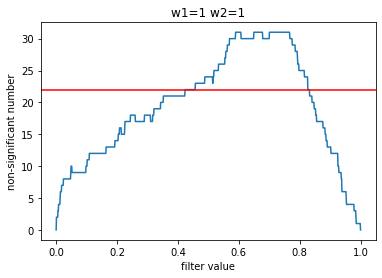

In [9]:
out_channels = 10
n_node = 38
num_features = n_node
for w1 in range(1, 2):
    for w2 in range(1, 2):
        VGAE_Encoder = Encoder(num_features, out_channels)
        model_ipf = VGAE(encoder = VGAE_Encoder, w1=w1, w2=w2)
        optimizer = torch.optim.Adam(model_ipf.parameters(), lr=0.005)
        epochs = 5000

        for epoch in range(epochs):
            loss_total = 0
            optimizer.zero_grad()

            for i in range(len(dataset)):
                train_data, val_data, test_data = transform(dataset[i])
                z = model_ipf.encode(train_data.x, train_data.edge_index)
                loss = model_ipf.recon_loss(z, train_data.edge_index) 
                loss = loss + 0.001 * 1/n_node * model_ipf.kl_loss()
                loss_total += loss

            loss_avg = loss_total/len(dataset)
            loss_avg.backward()
            optimizer.step()
            if epoch % 100 ==0:
                print(str(epoch)+str(loss_avg))
            # get mu and logstd 
            # os.chdir('C:\\Users\\Ji Qi\\Documents\\GitHub\\ST-Aim3')
            # os.getcwd()
            PATH = "./model/"+str(out_channels)+"w1="+str(w1)+"w2="+str(w2)+'_dim_vgae_model_for_ipfdata.pth'
            torch.save(model_ipf, PATH)

        mu_list_in_data = []
        logstd_list_in_data = []
        for i in range(len(dataset)):
            train_data, val_data, test_data = transform(dataset[i])
            mu = model_ipf.encode(train_data.x, train_data.edge_index)
            mu_list_in_data.append(np.asarray(mu.detach()))

        mu_list_reshape = []
        n = len(dataset)
        for i in range(n):
            mu_list_reshape.append(mu_list_in_data[i].reshape((out_channels * n_node)))

        # input data scatter 
        import matplotlib.pyplot as plt
        def plot_mu_graph(mu):
            n_node = mu.shape[0]
            annotations = [str(i+1) for i in range(n_node)]
            colors = plt.cm.rainbow(np.linspace(0, 1, n_node))
            plt.scatter(mu[:,0],mu[:,1],c=colors, s=100)

            for i, label in enumerate(annotations):
                plt.annotate(label, (mu[i,0], mu[i,1]), fontsize=14)

        # Gaussian distribution for generating mu

        import scipy.stats as stats
        data_mu = np.zeros((n, out_channels * n_node))
        for i in range(n):
            data_mu[i, :] = mu_list_reshape[i]

        from sklearn.mixture import GaussianMixture

        gm_mu = GaussianMixture(n_components=1, random_state=0).fit(data_mu)
        gm_mu.weights_[0] = 1  

        # got mean and cov for mu generating distribution
        means_normal = gm_mu.means_
        cov_normal = gm_mu.covariances_
        means_normal = np.asarray(means_normal.tolist()[0])
        cov_normal = np.asarray(cov_normal.tolist()[0])

        def sample_adj_mat(model=model_ipf,filter_option=True, filter_value=0.75, filter_eye=True):
            model.__mu__ = torch.from_numpy((np.random.multivariate_normal(mean=means_normal,cov=cov_normal)).reshape((n_node,out_channels)))
            z = model.__mu__
            model.decode(z, edge_index)
            adj_mat = np.zeros((n_node, n_node))
            for i in range(n_node*n_node):
                adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
            if filter_option==True:   
                adj_mat[adj_mat < filter_value] = 0
                adj_mat[adj_mat >= filter_value] = 1
            if filter_eye:
                for i in range(adj_mat.shape[0]):
                    adj_mat[i,i]=0
            return adj_mat, model.__mu__
        
        # generate adjacency matrices

        output_cent_list = []
        mu_list = []
        output_adj_list = []
        gen_size = 1000

        for i in range(gen_size):
            adj_mat, mu_sample = sample_adj_mat(model=model_ipf, filter_option=False, filter_value=0, filter_eye=True)
            output_adj_list.append(adj_mat)
            output_cent_list.append(compute_cent(adj_mat))
        ipf_output_cent_list = output_cent_list
        ipf_output_adj_list = output_adj_list
        
        # conpute input centralities
        input_adj_list = []
        input_cent_list = []
        for i in range(n):
            adj_mat = ipf_data.get_adj_m()[i]
            input_adj_list.append(adj_mat)
            input_cent_list.append(compute_cent(adj_mat))
            
        from scipy import stats
        res = stats.ttest_ind(output_cent_list, input_cent_list, 
                              equal_var=True, axis=0)
        print(np.mean(res.pvalue>=0.05/19))
        raw_non_sig_num = np.sum(res.pvalue>=0.05/19)
        
        import copy
        
        not_significant_num = []
        for fv in np.linspace(0,1,1000):
            adj_mat_list_temp = []
            output_cent_list_temp = []
            for adj in output_adj_list:
                adj_temp = copy.copy(adj)
                adj_temp[adj_temp < fv] = 0
                adj_temp[adj_temp >= fv] = 1
                adj_mat_list_temp.append(adj_temp)
                output_cent_list_temp.append(compute_cent(adj_temp))
            res = stats.ttest_ind(output_cent_list_temp, input_cent_list, equal_var=True, axis=0)
            not_significant_num.append(np.sum(res.pvalue>0.05/19)+38-(n_node))

        plt.plot(np.linspace(0,1,1000), not_significant_num)
        plt.title("w1="+str(w1)+" w2="+str(w2))
        plt.xlabel("filter value")
        plt.ylabel("non-significant number")
        plt.axhline(y=raw_non_sig_num, color='r', linestyle='-')
        print(np.max(not_significant_num))

In [13]:
# os.chdir('C:\\Users\\Ji Qi\\Documents\\GitHub\\ST-Aim3')
# os.getcwd()
PATH = "./model/"+str(out_channels)+'_dim_vgae_model_for_ipfdata.pth'
torch.save(model, PATH)

model = torch.load(PATH)
model.eval()

VGAE(
  (encoder): Encoder(
    (conv1): GCNConv(38, 20)
    (conv_mu): GCNConv(20, 10)
    (conv_logstd): GCNConv(20, 10)
  )
  (decoder): InnerProductDecoder()
)

## Generate IPF matrices

## t-test between IPF input and output

In [10]:
# t-test between IPF input and output

output_adj_list = []
output_cent_list = []
adj_mat_list = []
mu_list = []
gen_size = 1000
for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(model=model_ipf, filter_option=True, filter_value=0.7, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
    adj_mat_list.append(adj_mat)
    mu_list.append(mu_sample.detach().numpy())
input_adj_list = []
input_cent_list = []
for i in range(32):
    adj_mat = ipf_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
res = stats.ttest_ind(output_cent_list, input_cent_list, 
                  equal_var=True, axis=0)
np.sum(res.pvalue>0.05/19)

31

In [128]:
res=stats.ttest_ind(output_cent_list[300:400], output_cent_list[100:200], 
                  equal_var=True, axis=0)
pd.DataFrame(res.pvalue).T

,0
0,0.673475
1,0.928924
2,0.134727
3,0.930048
4,0.616628
5,0.912415
6,0.268475
7,0.020074
8,0.981868
9,0.350196


In [137]:
from scipy.stats import chi2
chi2.ppf(0.95, 1)

3.841458820694124

In [18]:
# t-test between IPF input and output vs. generation sizes

output_adj_list = []
output_cent_list = []
adj_mat_list = []
mu_list = []
fv = 0.7
p_value_table = pd.DataFrame()
for gen_size in range(100, 1200, 200):
    for i in range(gen_size):
        adj_mat, mu_sample = sample_adj_mat(model=model_ipf, filter_option=True, filter_value=fv, filter_eye=True)
        output_adj_list.append(adj_mat)
        output_cent_list.append(compute_cent(adj_mat))
        mu_list.append(mu_sample.detach().numpy())
    input_adj_list = []
    input_cent_list = []
    for i in range(32):
        adj_mat = ipf_data.get_adj_m()[i]
        input_adj_list.append(adj_mat)
        input_cent_list.append(compute_cent(adj_mat))
    res = stats.ttest_ind(output_cent_list, input_cent_list, 
                      equal_var=True, axis=0)
    p_value_table = pd.concat([p_value_table, pd.DataFrame(res.pvalue)], axis=1)

In [22]:
p_value_table.columns = range(100, 1200, 200)
p_value_table

,100,300,500,700,900,1100
0,3.309881e-01,1.559016e-01,1.273603e-01,8.239657e-02,8.803838e-02,9.504956e-02
1,1.420861e-01,2.786800e-02,3.097330e-02,2.762528e-02,3.056997e-02,2.927814e-02
2,3.350880e-01,4.292939e-01,3.906344e-01,4.105435e-01,4.660375e-01,4.289887e-01
3,4.273387e-01,3.652149e-01,4.421842e-01,4.518541e-01,4.995391e-01,6.224363e-01
4,2.107884e-08,1.227569e-15,1.384495e-19,4.739588e-21,6.571198e-21,2.827000e-21
5,4.907585e-08,1.430345e-11,9.753569e-13,7.994673e-13,2.358275e-12,1.596005e-12
6,2.832598e-07,6.845519e-11,1.066799e-11,9.082768e-12,3.852604e-11,2.395196e-11
7,5.071335e-01,2.422157e-01,1.420944e-01,1.508856e-01,1.714618e-01,1.666518e-01
8,8.592088e-02,5.794749e-02,2.741629e-02,2.740498e-02,3.591771e-02,4.220016e-02
9,5.307764e-01,3.661349e-01,2.712029e-01,2.279714e-01,2.541782e-01,2.643540e-01


In [23]:
# recover to sparse matrices
ipf_output_cent_list = output_cent_list
ipf_output_adj_list = output_adj_list

full_ipf_output_adj_list = []
full_ipf_output_cent_list = []

for i in range(gen_size):
    full_ipf_output_adj_list.append(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list))
    full_ipf_output_cent_list.append(compute_cent(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list)))

## t-test between IPF input and control input

In [28]:
raw_ipf_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/IPF"), file_path="./vgae_data/result_all_raw/EGF/IPF", non_orphan_list=range(38))
raw_ctrl_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/Control"), file_path="./vgae_data/result_all_raw/EGF/Control", non_orphan_list=range(38))

In [29]:
raw_ipf_cent_list = []
raw_ctrl_cent_list = []
for i in range(len(raw_ipf_data.get_adj_m())):
    adj_mat = raw_ipf_data.get_adj_m()[i]
    raw_ipf_cent_list.append(compute_cent(adj_mat))
    
for i in range(len(raw_ctrl_data.get_adj_m())):
    adj_mat = raw_ctrl_data.get_adj_m()[i]
    raw_ctrl_cent_list.append(compute_cent(adj_mat))
    
res = stats.ttest_ind(raw_ctrl_cent_list, raw_ipf_cent_list, 
                      equal_var=True, axis=0)
display(res)

Ttest_indResult(statistic=array([ -1.22613002,  -2.73267419,  -1.62763213,  -1.92845401,
        -6.44529234,  -5.69335965,  -5.24350011,  -6.05607094,
        -5.44453093,  -3.59767701,  -5.48108529,  -7.70520001,
        -4.17178166,  -6.28418729,  -4.47910071,  -3.96050302,
        -2.60178919,  -4.79646481,  -5.99732566,  -5.52539161,
        -4.34929447,  -5.37844245,  -5.51011443,  -2.12630116,
        -4.87126808, -19.01152631,   1.0614688 ,  -5.38696229,
        -5.22931327,  -4.63609494,  -2.91626105,  -3.61312494,
        -3.65880708,  -3.9572317 ,  -2.82862579,  -3.95609441,
        -2.12429365,  -7.23738612]), pvalue=array([2.25104704e-01, 8.31308666e-03, 1.09023825e-01, 5.86981223e-02,
       2.48756404e-08, 4.34012927e-07, 2.31092749e-06, 1.10139096e-07,
       1.09947451e-06, 6.64933155e-04, 9.59773860e-07, 1.91328661e-10,
       1.02382702e-04, 4.61275440e-08, 3.57332916e-05, 2.07011680e-04,
       1.17506764e-02, 1.16789902e-05, 1.37686764e-07, 8.13765939e-07,
       5

In [32]:
pd.DataFrame(res.pvalue)

,0
0,2.251047e-01
1,8.313087e-03
2,1.090238e-01
3,5.869812e-02
4,2.487564e-08
5,4.340129e-07
6,2.310927e-06
7,1.101391e-07
8,1.099475e-06
9,6.649332e-04


## Spectrum

In [ ]:
import numpy.linalg as linalg
output_spectrum = []
input_spectrum = []
for adj in output_adj_list:
    lam, v = linalg.eig(adj)
    output_spectrum.append(lam)
for adj in input_adj_list:
    lam, v = linalg.eig(adj)
    input_spectrum.append(lam) 

In [ ]:
import numpy.linalg as linalg
output_spectrum = []
input_spectrum = []
input_adj_list = ctrl_data.get_adj_m()
output_adj_list = ipf_data.get_adj_m()
for adj in raw_ipf_data.get_adj_m():
    lam, v = linalg.eig(adj)
    output_spectrum.append(lam)
for adj in raw_ctrl_data.get_adj_m():
    lam, v = linalg.eig(adj)
    input_spectrum.append(lam) 
spectrum_distance_matrix = np.empty((len(input_adj_list), len(output_adj_list)))
for i in range((len(input_adj_list))):
    for j in range(len(output_adj_list)):
        spectrum_distance_matrix[i, j] = compute_spectrum_distance(ipf_data.get_adj_m()[i], ipf_data.get_adj_m()[j])
spectrum_distance_matrix.shape

In [92]:
def compute_spectrum_distance(lam1, lam2):
    return linalg.norm((lam1-lam2), 2)

In [93]:
spectrum_distance_matrix = np.empty((len(input_adj_list), len(output_adj_list)))
for i in range((len(input_adj_list))):
    for j in range(len(output_adj_list)):
        spectrum_distance_matrix[i, j] = compute_spectrum_distance(input_spectrum[i], output_spectrum[j])

In [94]:
G0_G1_distance = spectrum_distance_matrix.flatten()

In [95]:
G0_distance = input_spectrum_distance_matrix.flatten()
G0_mean = np.mean(G0_distance)
G0_var = np.var(G0_distance)

NameError: name 'input_spectrum_distance_matrix' is not defined

In [ ]:
G0_G1_mean = np.mean(G0_G1_distance)
G0_G1_mean

In [ ]:
(G0_G1_mean - G0_mean) ** 2 / (G0_var)

In [ ]:
G0_mean

In [ ]:
G0_var

In [ ]:
np.around(np.mean(np.vstack(input_cent_list), axis=0) - np.mean(np.vstack(output_cent_list), axis=0), decimals=2)

In [96]:
import numpy.linalg as linalg
output_spectrum = []
input_spectrum = []
input_adj_list = ctrl_data.get_adj_m()
output_adj_list = ipf_data.get_adj_m()
for adj in raw_ipf_data.get_adj_m():
    lam, v = linalg.eig(adj)
    output_spectrum.append(lam)
for adj in raw_ctrl_data.get_adj_m():
    lam, v = linalg.eig(adj)
    input_spectrum.append(lam) 
spectrum_distance_matrix = np.empty((len(input_adj_list), len(output_adj_list)))
for i in range((len(input_adj_list))):
    for j in range(len(output_adj_list)):
        spectrum_distance_matrix[i, j] = compute_spectrum_distance(raw_ipf_data.get_adj_m()[i], raw_ipf_data.get_adj_m()[j])
spectrum_distance_matrix.shape

KeyboardInterrupt: 

## Data Summary

In [ ]:
ipf_output_cent_list

ipf_output_adj_list 

ipf_input_adj_list 

ipf_input_cent_list 

full_ipf_input_adj_list 

full_ipf_input_cent_list 

full_ipf_output_adj_list 

full_ipf_output_cent_list 

In [ ]:
full_ctrl_input_adj_list
full_ctrl_input_cent_list
ctrl_input_adj_list
ctrl_input_cent_list
full_ctrl_output_adj_list 
full_ctrl_output_cent_list 
ctrl_output_cent_list
ctrl_output_adj_list 

In [55]:
(full_ipf_output_cent_list)[100]

matrix([[0.63157895, 0.84210526, 0.39473684, 0.73684211, 0.84210526,
         0.84210526, 0.84210526, 0.81578947, 0.73684211, 0.05263158,
         0.05263158, 0.05263158, 0.84210526, 0.84210526, 0.47368421,
         0.68421053, 0.84210526, 0.05263158, 0.76315789, 0.76315789,
         0.71052632, 0.63157895, 0.78947368, 0.71052632, 0.78947368,
         0.81578947, 0.73684211, 0.47368421, 0.84210526, 0.84210526,
         0.63157895, 0.47368421, 0.07894737, 0.84210526, 0.84210526,
         0.81578947, 0.57894737, 0.71052632]])

# Ctrl data

## Load and train Ctrl data

In [33]:
full_ctrl_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/Control"), file_path="./vgae_data/result_all_raw/EGF/Control", non_orphan_list=range(38))
full_ctrl_input_adj_list = []
full_ctrl_input_cent_list = []
n = len(full_ctrl_data.get_adj_m())
for i in range(n):
    adj_mat = full_ctrl_data.get_adj_m()[i]
    full_ctrl_input_adj_list.append(adj_mat)
    full_ctrl_input_cent_list.append(compute_cent(adj_mat))
mean_input_cent = np.mean(full_ctrl_input_cent_list, axis=0)
np.argwhere(mean_input_cent != 0).T[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37])

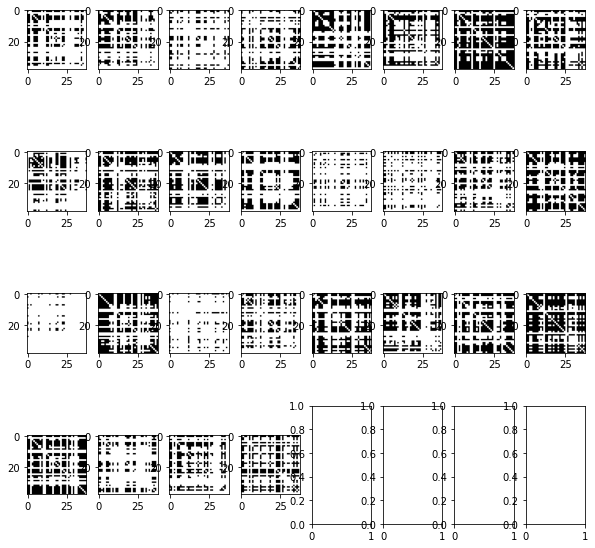

In [38]:
# non-orphan nodes
non_orphan_list = range(38)
ctrl_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/Control"), file_path="./vgae_data/result_all_raw/EGF/Control", non_orphan_list=non_orphan_list)
dataset = ctrl_data.graph_dataset()
input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
ctrl_input_adj_list = input_adj_list
ctrl_input_cent_list = input_cent_list

# original adj matrices
n_node = len(non_orphan_list)
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 8, figsize=(10,10))
for i in range(n):
    plt.subplot(4, 8, i+1)
    plt.imshow(ctrl_data.get_adj_m()[i], cmap="Greys")

0tensor(1.3669, grad_fn=<DivBackward0>)
100tensor(0.3811, grad_fn=<DivBackward0>)
200tensor(0.3438, grad_fn=<DivBackward0>)
300tensor(0.3271, grad_fn=<DivBackward0>)
400tensor(0.3242, grad_fn=<DivBackward0>)
500tensor(0.3142, grad_fn=<DivBackward0>)
600tensor(0.3071, grad_fn=<DivBackward0>)
700tensor(0.3031, grad_fn=<DivBackward0>)
800tensor(0.2936, grad_fn=<DivBackward0>)
900tensor(0.2846, grad_fn=<DivBackward0>)
1000tensor(0.2807, grad_fn=<DivBackward0>)
1100tensor(0.2765, grad_fn=<DivBackward0>)
1200tensor(0.2705, grad_fn=<DivBackward0>)
1300tensor(0.2628, grad_fn=<DivBackward0>)
1400tensor(0.2680, grad_fn=<DivBackward0>)
1500tensor(0.2572, grad_fn=<DivBackward0>)
1600tensor(0.2561, grad_fn=<DivBackward0>)
1700tensor(0.2527, grad_fn=<DivBackward0>)
1800tensor(0.2472, grad_fn=<DivBackward0>)
1900tensor(0.2482, grad_fn=<DivBackward0>)
2000tensor(0.2457, grad_fn=<DivBackward0>)
2100tensor(0.2443, grad_fn=<DivBackward0>)
2200tensor(0.2476, grad_fn=<DivBackward0>)
2300tensor(0.2459, grad

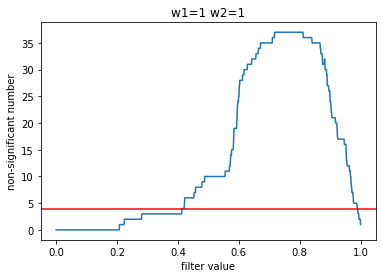

In [42]:
out_channels = 10
n_node = 38
num_features = n_node
for w1 in range(1, 2):
    for w2 in range(1, 2):
        VGAE_Encoder = Encoder(num_features, out_channels)
        model_ctrl = VGAE(encoder = VGAE_Encoder, w1=w1, w2=w2)
        optimizer = torch.optim.Adam(model_ctrl.parameters(), lr=0.005)
        epochs = 5000

        for epoch in range(epochs):
            loss_total = 0
            optimizer.zero_grad()

            for i in range(len(dataset)):
                train_data, val_data, test_data = transform(dataset[i])
                z = model_ctrl.encode(train_data.x, train_data.edge_index)
                loss = model_ctrl.recon_loss(z, train_data.edge_index) 
                loss = loss + 0.001 * 1/n_node * model_ctrl.kl_loss()
                loss_total += loss

            loss_avg = loss_total/len(dataset)
            loss_avg.backward()
            optimizer.step()
            if epoch % 100 ==0:
                print(str(epoch)+str(loss_avg))
            # get mu and logstd 
            # os.chdir('C:\\Users\\Ji Qi\\Documents\\GitHub\\ST-Aim3')
            # os.getcwd()
            PATH = "./model/"+str(out_channels)+"w1="+str(w1)+"w2="+str(w2)+'_dim_vgae_model_for_ctrldata.pth'
            torch.save(model_ctrl, PATH)

        mu_list_in_data = []
        logstd_list_in_data = []
        for i in range(len(dataset)):
            train_data, val_data, test_data = transform(dataset[i])
            mu = model_ctrl.encode(train_data.x, train_data.edge_index)
            mu_list_in_data.append(np.asarray(mu.detach()))

        mu_list_reshape = []
        n = len(dataset)
        for i in range(n):
            mu_list_reshape.append(mu_list_in_data[i].reshape((out_channels * n_node)))

        # input data scatter 
        import matplotlib.pyplot as plt
        def plot_mu_graph(mu):
            n_node = mu.shape[0]
            annotations = [str(i+1) for i in range(n_node)]
            colors = plt.cm.rainbow(np.linspace(0, 1, n_node))
            plt.scatter(mu[:,0],mu[:,1],c=colors, s=100)

            for i, label in enumerate(annotations):
                plt.annotate(label, (mu[i,0], mu[i,1]), fontsize=14)

        # Gaussian distribution for generating mu

        import scipy.stats as stats
        data_mu = np.zeros((n, out_channels * n_node))
        for i in range(n):
            data_mu[i, :] = mu_list_reshape[i]

        from sklearn.mixture import GaussianMixture

        gm_mu = GaussianMixture(n_components=1, random_state=0).fit(data_mu)
        gm_mu.weights_[0] = 1  

        # got mean and cov for mu generating distribution
        means_normal = gm_mu.means_
        cov_normal = gm_mu.covariances_
        means_normal = np.asarray(means_normal.tolist()[0])
        cov_normal = np.asarray(cov_normal.tolist()[0])

        def sample_adj_mat(model=model_ipf,filter_option=True, filter_value=0.75, filter_eye=True):
            model.__mu__ = torch.from_numpy((np.random.multivariate_normal(mean=means_normal,cov=cov_normal)).reshape((n_node,out_channels)))
            z = model.__mu__
            model.decode(z, edge_index)
            adj_mat = np.zeros((n_node, n_node))
            for i in range(n_node*n_node):
                adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
            if filter_option==True:   
                adj_mat[adj_mat < filter_value] = 0
                adj_mat[adj_mat >= filter_value] = 1
            if filter_eye:
                for i in range(adj_mat.shape[0]):
                    adj_mat[i,i]=0
            return adj_mat, model.__mu__
        
        # generate adjacency matrices

        output_cent_list = []
        mu_list = []
        output_adj_list = []
        gen_size = 1000

        for i in range(gen_size):
            adj_mat, mu_sample = sample_adj_mat(model=model_ctrl, filter_option=False, filter_value=0, filter_eye=True)
            output_adj_list.append(adj_mat)
            output_cent_list.append(compute_cent(adj_mat))
        ctrl_output_cent_list = output_cent_list
        ctrl_output_adj_list = output_adj_list
        
        # conpute input centralities
        input_adj_list = []
        input_cent_list = []
        for i in range(n):
            adj_mat = ctrl_data.get_adj_m()[i]
            input_adj_list.append(adj_mat)
            input_cent_list.append(compute_cent(adj_mat))
            
        from scipy import stats
        res = stats.ttest_ind(output_cent_list, input_cent_list, 
                              equal_var=True, axis=0)
        print(np.mean(res.pvalue>=0.05/19))
        raw_non_sig_num = np.sum(res.pvalue>=0.05/19)
        
        import copy
        
        not_significant_num = []
        for fv in np.linspace(0,1,1000):
            adj_mat_list_temp = []
            output_cent_list_temp = []
            for adj in output_adj_list:
                adj_temp = copy.copy(adj)
                adj_temp[adj_temp < fv] = 0
                adj_temp[adj_temp >= fv] = 1
                adj_mat_list_temp.append(adj_temp)
                output_cent_list_temp.append(compute_cent(adj_temp))
            res = stats.ttest_ind(output_cent_list_temp, input_cent_list, equal_var=True, axis=0)
            not_significant_num.append(np.sum(res.pvalue>0.05/19)+38-(n_node))

        plt.plot(np.linspace(0,1,1000), not_significant_num)
        plt.title("w1="+str(w1)+" w2="+str(w2))
        plt.xlabel("filter value")
        plt.ylabel("non-significant number")
        plt.axhline(y=raw_non_sig_num, color='r', linestyle='-')
        print(np.max(not_significant_num))

In [54]:
# os.chdir('C:\\Users\\Ji Qi\\Documents\\GitHub\\ST-Aim3')
# os.getcwd()
PATH = str(out_channels)+'_dim_vgae_model_for_ctrldata.pth'
# torch.save(model, PATH)

model = torch.load(PATH)
model.eval()

VGAE(
  (encoder): Encoder(
    (conv1): GCNConv(19, 4)
    (conv_mu): GCNConv(4, 2)
    (conv_logstd): GCNConv(4, 2)
  )
  (decoder): InnerProductDecoder()
)

In [51]:
npnp.array(not_significant_num) == 37

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

## Generate Ctrl matrices

In [106]:
# t-test between IPF input and output vs. generation sizes
p_value_table_ivo = pd.DataFrame()
output_adj_list = []
output_cent_list = []
adj_mat_list = []
mu_list = []
output_cent_list = full_ctrl_output_cent_list
# fv = 0.71
# p_value_table = pd.DataFrame()
# gen_size = 1000
# for i in range(gen_size):
#     adj_mat, mu_sample = sample_adj_mat(model=model_ctrl, filter_option=True, filter_value=fv, filter_eye=True)
#     output_adj_list.append(adj_mat)
#     output_cent_list.append(compute_cent(adj_mat))
#     mu_list.append(mu_sample.detach().numpy())
# input_adj_list = []
# input_cent_list = []
for i in range(n):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
for i in range(100, 1200, 100):
    res = stats.ttest_ind(output_cent_list[0:i], input_cent_list[0:i], equal_var=True, axis=0)
    p_value_table_ivo = pd.concat([p_value_table_ivo, pd.DataFrame(res.pvalue)], axis=1)

In [113]:
p_value_table_ivo = p_value_table_ivo.T
p_value_table_ivo.columns = range(100, 1200, 100)

In [114]:
p_value_table_ivo

,100,200,300,400,500,600,700,800,900,1000,1100
0,4.137946e-01,1.009337e-01,6.186234e-02,2.421409e-02,1.871967e-02,1.174045e-02,8.787474e-03,1.293573e-02,1.353815e-02,6.979523e-03,6.979523e-03
1,5.672375e-01,3.705770e-01,2.305751e-01,2.040409e-01,2.462349e-01,4.187013e-01,3.038582e-01,2.097712e-01,1.987238e-01,2.556090e-01,2.556090e-01
2,1.993950e-01,3.912378e-01,2.615375e-01,1.301315e-01,9.609301e-02,1.822035e-01,1.488146e-01,1.480612e-01,1.649446e-01,1.051352e-01,1.051352e-01
3,3.889778e-01,1.605982e-01,1.339174e-01,9.274479e-02,5.262303e-02,1.063807e-01,4.774438e-02,6.553986e-02,9.285973e-02,7.417737e-02,7.417737e-02
4,2.433467e-01,7.137484e-02,3.835451e-02,4.215793e-02,6.163579e-02,6.703116e-02,1.567701e-02,7.952042e-03,5.822709e-03,8.712346e-03,8.712346e-03
5,7.758278e-01,9.561281e-01,8.481485e-01,9.012019e-01,9.906958e-01,7.229056e-01,9.608540e-01,9.791588e-01,9.658314e-01,8.183267e-01,8.183267e-01
6,7.192754e-01,3.130003e-01,1.933006e-01,2.607338e-01,2.366461e-01,3.515967e-01,1.364121e-01,9.771253e-02,9.136654e-02,1.083579e-01,1.083579e-01
7,1.093746e-03,9.330346e-07,1.010191e-06,1.540711e-06,7.115452e-07,9.502407e-07,2.209199e-07,3.543980e-07,5.864295e-08,6.471931e-08,6.471931e-08
8,1.680135e-01,5.113580e-02,8.504170e-03,9.580375e-03,2.744913e-02,6.052533e-02,5.187021e-02,3.606223e-02,3.037047e-02,4.916512e-02,4.916512e-02
9,2.033481e-02,1.003400e-01,1.844817e-01,4.382486e-01,3.426068e-01,4.360672e-01,4.263251e-01,5.035186e-01,3.950636e-01,3.705124e-01,3.705124e-01


In [ ]:
output_adj_list = []
output_cent_list = []
adj_mat_list = []
mu_list = []
fv = 0.7
p_value_table = pd.DataFrame()
for gen_size in range(100, 1200, 200):
    for i in range(gen_size):
        adj_mat, mu_sample = sample_adj_mat(model=model_ipf, filter_option=True, filter_value=fv, filter_eye=True)
        output_adj_list.append(adj_mat)
        output_cent_list.append(compute_cent(adj_mat))
        mu_list.append(mu_sample.detach().numpy())
    input_adj_list = []
    input_cent_list = []
    for i in range(32):
        adj_mat = ipf_data.get_adj_m()[i]
        input_adj_list.append(adj_mat)
        input_cent_list.append(compute_cent(adj_mat))
    res = stats.ttest_ind(output_cent_list, input_cent_list, 
                      equal_var=True, axis=0)
    p_value_table = pd.concat([p_value_table, pd.DataFrame(res.pvalue)], axis=1)

In [58]:
# conpute input centralities
input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))

In [58]:
# t-test between raw input and output 
from scipy import stats
res = stats.ttest_ind(output_cent_list, input_cent_list, 
                      equal_var=True, axis=0)
display(res)
pd.DataFrame(np.around(res.pvalue, decimals=3))

Ttest_indResult(statistic=array([-1.14658683,  0.53862288,  0.64600436,  0.70600302,  1.15792473,
       -0.10110715,  0.71301031,  2.34676336,  0.77572053,  0.3585377 ,
        0.08986599,  2.24234114, -0.03000497,  1.56765875,  0.63441255,
        0.26284178,  3.39653918,  0.88829526,  2.96077786,  2.38421972,
        0.23394172,  0.42836011,  3.00655818,  1.93820945,  0.55982999,
        3.02357273,  1.63404389,  0.26664874,  0.36333786,  0.54552134,
       -0.17457346, -0.32110454,  0.22769189,  1.10588653,  0.64066071,
        0.92027154,  1.13282007,  0.87040004]), pvalue=array([2.51819746e-01, 5.90263937e-01, 5.18420986e-01, 4.80346536e-01,
       2.47164227e-01, 9.19485158e-01, 4.76001507e-01, 1.91266892e-02,
       4.38092781e-01, 7.20014718e-01, 9.28411247e-01, 2.51522896e-02,
       9.76068922e-01, 1.17269138e-01, 5.25953045e-01, 7.92725304e-01,
       7.08613411e-04, 3.74590148e-01, 3.13924592e-03, 1.72963247e-02,
       8.15076894e-01, 6.68478871e-01, 2.70656638e-03, 5.287

,0
0,0.252
1,0.590
2,0.518
3,0.480
4,0.247
5,0.919
6,0.476
7,0.019
8,0.438
9,0.720


## t-test between Ctrl input and output

In [19]:
# Find the best filter value and t-test

not_significant_num = []
gen_size = 100
for fv in np.linspace(0.6,0.8,21):
    output_adj_list = []
    output_cent_list = []
    adj_mat_list = []
    mu_list = []
    for i in range(gen_size):
        adj_mat, mu_sample = sample_adj_mat(filter_value=fv, filter_eye=True)
        output_adj_list.append(adj_mat)
        output_cent_list.append(compute_cent(adj_mat))
        adj_mat_list.append(adj_mat)
        mu_list.append(mu_sample.detach().numpy())
    res = stats.ttest_ind(output_cent_list, input_cent_list, equal_var=True, axis=0)
    not_significant_num.append(np.sum(res.pvalue>0.05/38))
    


In [20]:
not_significant_num

[13,
 13,
 14,
 15,
 15,
 16,
 16,
 16,
 17,
 17,
 17,
 17,
 19,
 18,
 18,
 19,
 19,
 19,
 19,
 19,
 18]

In [69]:
# t-test between Ctrl input and output

output_adj_list = []
output_cent_list = []
adj_mat_list = []
mu_list = []
gen_size = 100
for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(filter_value=0.7, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
    adj_mat_list.append(adj_mat)
    mu_list.append(mu_sample.detach().numpy())
input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
res = stats.ttest_ind(output_cent_list, input_cent_list, 
                  equal_var=True, axis=0)
np.sum(res.pvalue>0.05/19)

17

In [59]:
# recover to sparse matrices

full_ctrl_output_adj_list = []
full_ctrl_output_cent_list = []
for i in range(gen_size):
    full_ctrl_output_adj_list.append(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list))
    full_ctrl_output_cent_list.append(compute_cent(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list)))

## t-test beteen IPF output and Ctrl output

In [88]:
p_value_table = pd.DataFrame()
for k in range(200, 2000, 100):
    res = stats.ttest_ind(full_ipf_output_cent_list[0:k], full_ctrl_output_cent_list[0:k], 
                      equal_var=True, axis=0)
    for i in range(len(res.pvalue[0])):
        res.pvalue[0][i] = np.format_float_scientific(res.pvalue[0][i], unique=False, precision=2)
    p_value_table = pd.concat([p_value_table, pd.DataFrame(res.pvalue)], axis=0)

In [81]:
full_ctrl_output_cent_list[1799:1800]

[]

In [89]:
p_value_table = p_value_table.T
p_value_table.columns = range(200, 2000, 100)
# p_value_table = "{:.2e}".format(p_value_table)

In [90]:
p_value_table

,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900
0,5.290000e-03,1.030000e-04,9.590000e-08,9.260000e-11,1.460000e-11,3.790000e-12,1.680000e-13,4.860000e-14,1.070000e-16,1.110000e-14,1.110000e-14,1.110000e-14,1.110000e-14,1.110000e-14,1.110000e-14,1.110000e-14,1.110000e-14,1.110000e-14
1,6.120000e-07,3.360000e-14,5.360000e-20,3.460000e-28,4.110000e-38,1.120000e-41,8.090000e-48,9.540000e-56,1.610000e-66,4.820000e-68,4.820000e-68,4.820000e-68,4.820000e-68,4.820000e-68,4.820000e-68,4.820000e-68,4.820000e-68,4.820000e-68
2,1.070000e-06,4.620000e-08,1.990000e-08,7.270000e-10,1.140000e-13,2.220000e-15,4.290000e-17,3.820000e-19,3.940000e-20,2.930000e-21,2.930000e-21,2.930000e-21,2.930000e-21,2.930000e-21,2.930000e-21,2.930000e-21,2.930000e-21,2.930000e-21
3,1.790000e-06,2.300000e-07,1.360000e-09,5.070000e-11,3.380000e-14,1.360000e-14,5.760000e-16,6.240000e-18,2.050000e-18,2.940000e-19,2.940000e-19,2.940000e-19,2.940000e-19,2.940000e-19,2.940000e-19,2.940000e-19,2.940000e-19,2.940000e-19
4,9.580000e-42,7.970000e-61,2.430000e-82,1.970000e-103,7.770000e-126,2.340000e-138,1.650000e-155,6.170000e-174,1.530000e-197,6.350000e-214,6.350000e-214,6.350000e-214,6.350000e-214,6.350000e-214,6.350000e-214,6.350000e-214,6.350000e-214,6.350000e-214
5,1.710000e-33,2.000000e-48,2.730000e-65,7.640000e-83,2.600000e-100,1.780000e-109,1.270000e-125,1.310000e-141,5.340000e-164,3.060000e-175,3.060000e-175,3.060000e-175,3.060000e-175,3.060000e-175,3.060000e-175,3.060000e-175,3.060000e-175,3.060000e-175
6,1.160000e-33,2.140000e-49,1.220000e-67,3.320000e-86,9.230000e-105,5.220000e-116,1.090000e-129,5.730000e-146,1.850000e-165,1.230000e-178,1.230000e-178,1.230000e-178,1.230000e-178,1.230000e-178,1.230000e-178,1.230000e-178,1.230000e-178,1.230000e-178
7,1.350000e-36,1.010000e-53,3.470000e-74,8.830000e-93,6.620000e-110,3.650000e-116,3.990000e-131,2.450000e-145,3.220000e-160,4.770000e-172,4.770000e-172,4.770000e-172,4.770000e-172,4.770000e-172,4.770000e-172,4.770000e-172,4.770000e-172,4.770000e-172
8,2.260000e-26,5.380000e-38,2.440000e-51,1.700000e-72,5.420000e-92,6.650000e-102,5.520000e-115,9.750000e-130,3.980000e-152,8.430000e-159,8.430000e-159,8.430000e-159,8.430000e-159,8.430000e-159,8.430000e-159,8.430000e-159,8.430000e-159,8.430000e-159
9,3.190000e-03,3.130000e-04,1.320000e-08,3.460000e-08,1.160000e-10,1.720000e-11,2.130000e-14,6.130000e-15,2.700000e-16,9.230000e-17,9.230000e-17,9.230000e-17,9.230000e-17,9.230000e-17,9.230000e-17,9.230000e-17,9.230000e-17,9.230000e-17


In [94]:
np.format_float_scientific(res.pvalue[0][1], unique=False, precision=2)

'1.74e-152'

In [110]:
res = stats.ttest_ind(full_ipf_input_cent_list, full_ctrl_input_cent_list, 
                      equal_var=True, axis=0)
pd.DataFrame(res.pvalue).to_csv("input_p_value.csv")